In [12]:
# loadings and defaults
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage

import numpy.matlib
from xgcm import Grid
import matplotlib.ticker as mticker

%config InlineBackend.figure_format='png'



In [13]:
# my functions



def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})
    print('done renaming')
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])
    print('made grid object')

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta.mean(dim="ocean_time") + ds.zice + (ds.zeta.mean(dim="ocean_time") + ds.zice + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta.mean(dim="ocean_time") + ds.zice + ds.h) + ds.zeta.mean(dim="ocean_time") + ds.zice

    print('done making vertical coords')

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')
    print('done interpolation of depths')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)
    print('done interpolation of x,y')

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy
    print('made metrics')

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    print('assigned metrics')
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [14]:
norm = xr.open_dataset('../data/proc/tisom_his_0021_trimmed.nc')
gridFile=xr.open_dataset('../data/raw/tisom008_canal_grd.nc')
mask_zice = (norm.zice<0)
mask_zice_nan = mask_zice.where(mask_zice!=0.0,np.nan)

norm = processROMSGrid(norm)

norm['x_rho']=gridFile.x_rho
norm['y_rho']=gridFile.y_rho
norm = norm.set_coords(['x_rho','y_rho'])
# norm.ocean_time.values

noflow = xr.open_dataset('../data/proc/tisom_his_0021_NoFlow.nc')
noflow = processROMSGrid(noflow)
noflow['x_rho']=gridFile.x_rho
noflow['y_rho']=gridFile.y_rho
noflow = noflow.set_coords(['x_rho','y_rho'])
# noflow.ocean_time.values

done renaming
made grid object
done making vertical coords
done interpolation of depths
done interpolation of x,y
made metrics
assigned metrics
done renaming
made grid object
done making vertical coords
done interpolation of depths
done interpolation of x,y
made metrics
assigned metrics


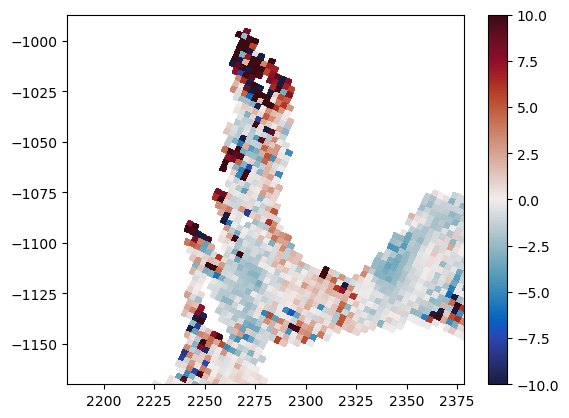

In [15]:
im=plt.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,((norm.m*365*60*60*24).mean(dim='ocean_time')-(noflow.m*365*60*60*24).mean(dim='ocean_time'))/(noflow.m*365*60*60*24).mean(dim='ocean_time')*100,vmin=-10,vmax=10,cmap='cmo.balance')
plt.axis('equal')
plt.xlim([2.240e3,2.32e3])
plt.ylim([-1.170e3,-.987e3])
plt.colorbar(im)


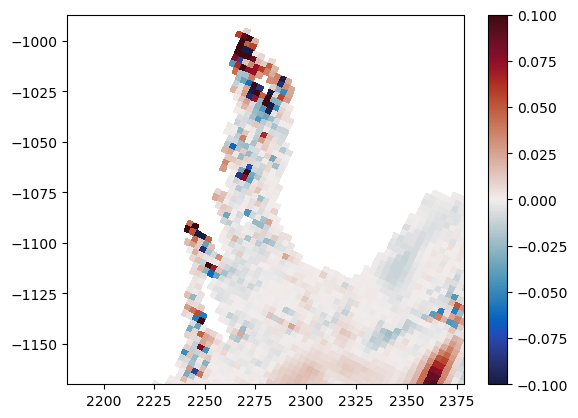

In [16]:
im=plt.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,norm.temp.isel(s_rho=-1).mean(dim='ocean_time')-noflow.temp.isel(s_rho=-1).mean(dim='ocean_time'),vmin=-.1,vmax=.1,cmap='cmo.balance')
plt.axis('equal')
plt.xlim([2.240e3,2.32e3])
plt.ylim([-1.170e3,-.987e3])
plt.colorbar(im)


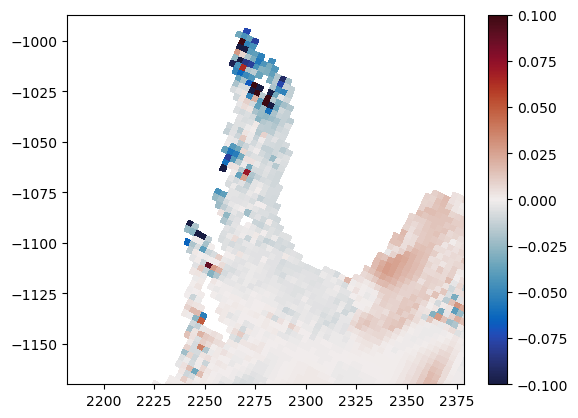

In [17]:
im=plt.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,norm.salt.isel(s_rho=-1).mean(dim='ocean_time')-noflow.salt.isel(s_rho=-1).mean(dim='ocean_time'),vmin=-.1,vmax=.1,cmap='cmo.balance')
plt.axis('equal')
plt.xlim([2.240e3,2.32e3])
plt.ylim([-1.170e3,-.987e3])
plt.colorbar(im)


In [18]:
norm

<xarray.Dataset>
Dimensions:        (tracer: 3, s_rho: 31, s_w: 32, boundary: 4, eta_rho: 260,
                    xi_rho: 381, ocean_time: 365, eta_v: 259, xi_u: 380)
Coordinates: (12/15)
    lat_psi        (eta_v, xi_u) float64 ...
    lat_rho        (eta_rho, xi_rho) float64 -67.59 -67.59 ... -60.02 -60.02
    lat_u          (eta_rho, xi_u) float64 ...
    lat_v          (eta_v, xi_rho) float64 ...
    lon_psi        (eta_v, xi_u) float64 ...
    lon_rho        (eta_rho, xi_rho) float64 104.6 104.7 104.7 ... 129.9 129.9
    ...             ...
  * s_rho          (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
  * s_w            (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.06452 -0.03226 0.0
    z_w            (s_w, eta_rho, xi_rho) float64 0.0 0.0 ... -0.03696 -0.03696
    z_rho          (s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... -0.8846 -0.8846
    x_rho          (eta_rho, xi_rho) float64 ...
    y_rho          (eta_rho, xi_rho) float64 ...
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_v, xi_u
Data variables: (12/94)
    Akt_bak        (tracer) float64 ...
    Akv_bak        float64 ...
    Cs_r           (s_rho) float64 ...
    Cs_w           (s_w) float64 ...
    FSobc_in       (boundary) float64 ...
    FSobc_out      (boundary) float64 ...
    ...             ...
    dz_w           (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.8846 0.8846
    dz_u           (s_rho, eta_rho, xi_u) float64 0.0 0.0 0.0 ... 2.75 2.75 2.75
    dz_w_u         (s_w, eta_rho, xi_u) float64 0.0 0.0 0.0 ... 0.8834 0.8846
    dz_v           (s_rho, eta_v, xi_rho) float64 0.0 0.0 0.0 ... 2.75 2.75 2.75
    dz_w_v         (s_w, eta_v, xi_rho) float64 0.0 0.0 0.0 ... 0.8846 0.8846
    dA             (eta_rho, xi_rho) float64 8.218e+06 8.218e+06 ... 1.5e+07
Attributes: (12/28)
    file:              tisom_his_0021.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             Totten Ice Shelf/Ocean Application
    rst_file:          tisom_rst.nc
    ...                ...
    compiler_flags:    -heap-arrays -fp-model precise -ip -O3 -free -free
    tiling:            016x018
    history:           Mon Nov  1 10:51:43 2021: ncks -O -x -v sustr,svstr,ss...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       TOTTEN_SGFW, ADD_FSOBC, ANA_BPFLUX, ANA_BSFLUX, ANA_BT...
    NCO:               netCDF Operators version 4.9.2 (Homepage = http://nco....

In [285]:
grid = makeROMSGridObject(norm)
depth_snapshot = norm['x_rho']
temp_500m = grid.transform(norm.temp.isel(ocean_time=360), 'X', np.array([2.285e6]),
                                target_data=depth_snapshot,
                                method='linear')

temp_500m#.isel(x_rho=0).plot(x='eta_rho',y='z_rho')


zz = grid.transform(norm.z_rho, 'X', np.array([2.285e6]),
                                target_data=depth_snapshot,
                                method='linear')

yy = grid.transform(norm.y_rho, 'X', np.array([2.285e6]),
                                target_data=depth_snapshot,
                                method='linear')



Z = zz.squeeze().fillna(20)

Y = yy.squeeze().fillna(-3e6)

plt.pcolormesh(Y,Z,temp_500m.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')
plt.xlim([-1.20e6,-1.0125e6])
#plt.xlim([-1.50e6,-.975e6])
plt.ylim([-2600,0])
plt.colorbar()

/home/woden/miniconda3/envs/devel3.10/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


ImportError: The transform functionality of xgcm requires numba. Install using `conda install numba`.

<ipython-input-271-57ca57dda654>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X,Z,temp_500m.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')


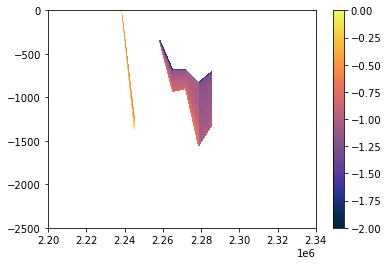

In [ ]:
grid = makeROMSGridObject(norm)
depth_snapshot = norm['y_rho']
temp_500m = grid.transform(norm.temp.isel(ocean_time=360), 'Y', np.array([-1.095e6]),
                                target_data=depth_snapshot,
                                method='linear')

temp_500m#.isel(x_rho=0).plot(x='eta_rho',y='z_rho')


zz = grid.transform(norm.z_rho, 'Y', np.array([-1.095e6]),
                                target_data=depth_snapshot,
                                method='linear')

xx = grid.transform(norm.x_rho, 'Y', np.array([-1.095e6]),
                                target_data=depth_snapshot,
                                method='linear')



Z = zz.squeeze().fillna(20)

X = xx.squeeze().fillna(-3e6)

plt.pcolormesh(X,Z,temp_500m.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')
plt.xlim([2.200e6,2.340e6])
plt.ylim([-2500,0])
plt.colorbar()

(10.0, 30.0)

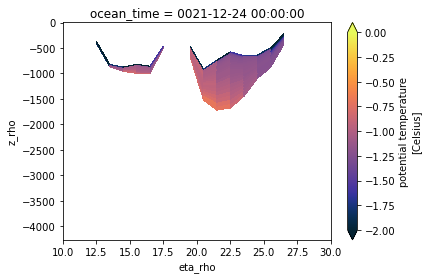

In [ ]:
norm.temp.isel(ocean_time=360,xi_rho=165).plot(y='z_rho',vmin=-2,vmax=0, cmap='cmo.thermal')
plt.xlim([10,30])


(140.0, 170.0)

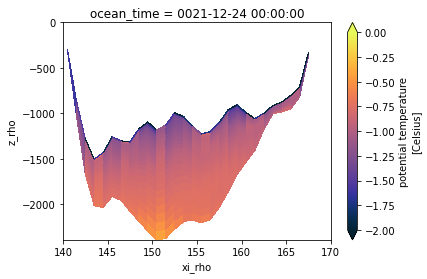

In [ ]:
norm.temp.isel(ocean_time=360,eta_rho=15).plot(y='z_rho',vmin=-2,vmax=0, cmap='cmo.thermal')
plt.xlim([140,170])

# NOW HONE EACH SUB PLOT INDIVIDUALLY

<ipython-input-274-47485a06a26c>:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(Y,Z,temp_500m.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')


<Figure size 432x288 with 0 Axes>

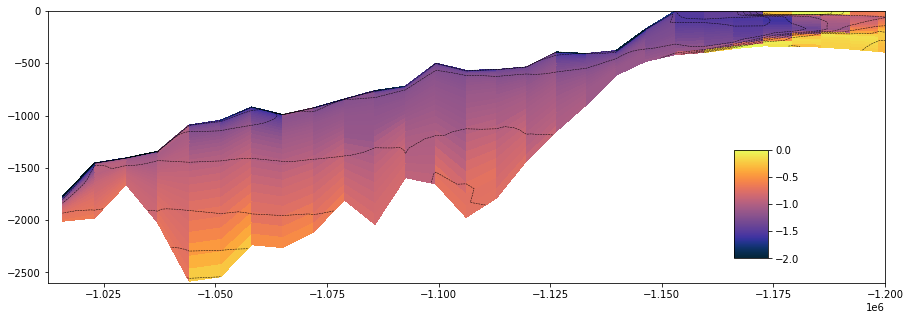

In [ ]:
grid = makeROMSGridObject(norm)
depth_snapshot = norm['x_rho']
temp_500m = grid.transform(norm.temp.isel(ocean_time=360), 'X', np.array([2.284e6]),
                                target_data=depth_snapshot,
                                method='linear')

temp_500m#.isel(x_rho=0).plot(x='eta_rho',y='z_rho')


zz = grid.transform(norm.z_rho, 'X', np.array([2.284e6]),
                                target_data=depth_snapshot,
                                method='linear')

yy = grid.transform(norm.y_rho, 'X', np.array([2.284e6]),
                                target_data=depth_snapshot,
                                method='linear')



Z = zz.squeeze().fillna(20)
Y = np.tile(yy.squeeze().fillna(-3e6),[31,1])





gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])
im=ax.pcolormesh(Y,Z,temp_500m.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')
co=ax.contour(Y,Z,temp_500m.squeeze(),levels=np.arange(-2,0,.25),colors='k',linewidths=0.5)
ax.set_xlim([-1.20e6,-1.0125e6])
#plt.xlim([-1.50e6,-.975e6])
ax.set_ylim([-2600,0])
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im,cax=cax)
ax.invert_xaxis()

<ipython-input-275-581a2ee2ec07>:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(X/1e3,Z,temp_500m.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')


<Figure size 432x288 with 0 Axes>

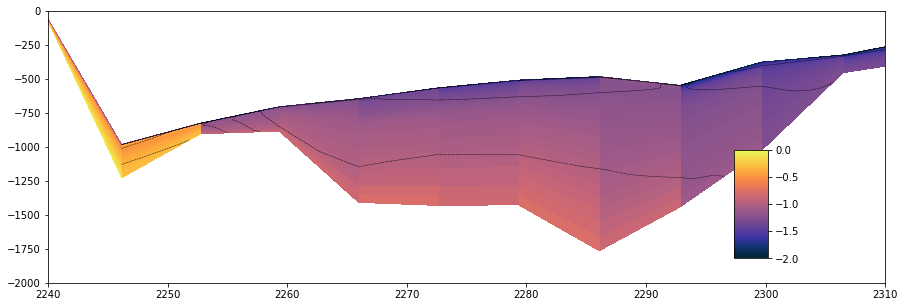

In [ ]:
grid = makeROMSGridObject(norm)
depth_snapshot = norm['y_rho']
temp_500m = grid.transform(norm.temp.isel(ocean_time=360), 'Y', np.array([-1.115e6]),
                                target_data=depth_snapshot,
                                method='linear')

temp_500m#.isel(x_rho=0).plot(x='eta_rho',y='z_rho')


zz = grid.transform(norm.z_rho, 'Y', np.array([-1.115e6]),
                                target_data=depth_snapshot,
                                method='linear')

xx = grid.transform(norm.x_rho, 'Y', np.array([-1.115e6]),
                                target_data=depth_snapshot,
                                method='linear')



Z = zz.squeeze().fillna(20)
X = np.tile(xx.squeeze().fillna(-3e6),[31,1])





gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])
im=ax.pcolormesh(X/1e3,Z,temp_500m.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')
co=ax.contour(X/1e3,Z,temp_500m.squeeze(),levels=np.arange(-2,0,.25),colors='k',linewidths=0.5)
plt.xlim([2.2400e6/1e3,2.310e6/1e3])
plt.ylim([-2000,0])
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im,cax=cax)


In [ ]:
X

NameError: name 'X' is not defined

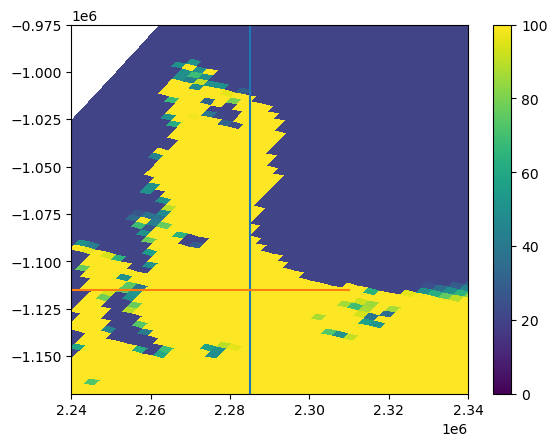

In [20]:
plt.pcolormesh(gridFile.x_rho,gridFile.y_rho,gridFile.h+gridFile.zice,vmin=0,vmax=100)
plt.xlim([2.240e6,2.340e6])
plt.ylim([-1.170e6,-.975e6])
plt.colorbar()
plt.plot([2.285e6,2.285e6],[-1.2e6,-.975e6])
plt.plot([2.24e6,2.31e6],[-1.115e6,-1.115e6])


In [21]:
grid = makeROMSGridObject(norm)

norm_depth_snapshot_1 = norm['y_rho']
norm_temp_1 = grid.transform(norm.temp.mean(dim='ocean_time'), 'Y', np.array([-1.115e6]),
                                target_data=norm_depth_snapshot_1,
                                method='linear')


norm_zz_1 = grid.transform(norm.z_rho, 'Y', np.array([-1.115e6]),
                                target_data=norm_depth_snapshot_1,
                                method='linear')

norm_xx_1 = grid.transform(norm.x_rho, 'Y', np.array([-1.115e6]),
                                target_data=norm_depth_snapshot_1,
                                method='linear')



norm_Z_1 = norm_zz_1.squeeze().fillna(20)
norm_X_1 = np.tile(norm_xx_1.squeeze().fillna(-3e6),[31,1])



norm_depth_snapshot_2 = norm['x_rho']
norm_temp_2 = grid.transform(norm.temp.mean(dim='ocean_time'), 'X', np.array([2.284e6]),
                                target_data=norm_depth_snapshot_2,
                                method='linear')


norm_zz_2 = grid.transform(norm.z_rho, 'X', np.array([2.284e6]),
                                target_data=norm_depth_snapshot_2,
                                method='linear')

norm_yy_2 = grid.transform(norm.y_rho, 'X', np.array([2.284e6]),
                                target_data=norm_depth_snapshot_2,
                                method='linear')



norm_Z_2 = norm_zz_2.squeeze().fillna(20)
norm_Y_2 = np.tile(norm_yy_2.squeeze().fillna(-3e6),[31,1])

/home/woden/miniconda3/envs/devel3.10/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


ImportError: The transform functionality of xgcm requires numba. Install using `conda install numba`.

In [ ]:
grid = makeROMSGridObject(noflow)

noflow_depth_snapshot_1 = noflow['y_rho']
noflow_temp_1 = grid.transform(noflow.temp.mean(dim='ocean_time'), 'Y', np.array([-1.115e6]),
                                target_data=noflow_depth_snapshot_1,
                                method='linear')


noflow_zz_1 = grid.transform(noflow.z_rho, 'Y', np.array([-1.115e6]),
                                target_data=noflow_depth_snapshot_1,
                                method='linear')

noflow_xx_1 = grid.transform(noflow.x_rho, 'Y', np.array([-1.115e6]),
                                target_data=noflow_depth_snapshot_1,
                                method='linear')



noflow_Z_1 = noflow_zz_1.squeeze().fillna(20)
noflow_X_1 = np.tile(noflow_xx_1.squeeze().fillna(-3e6),[31,1])



noflow_depth_snapshot_2 = noflow['x_rho']
noflow_temp_2 = grid.transform(noflow.temp.mean(dim='ocean_time'), 'X', np.array([2.284e6]),
                                target_data=noflow_depth_snapshot_2,
                                method='linear')


noflow_zz_2 = grid.transform(noflow.z_rho, 'X', np.array([2.284e6]),
                                target_data=noflow_depth_snapshot_2,
                                method='linear')

noflow_yy_2 = grid.transform(noflow.y_rho, 'X', np.array([2.284e6]),
                                target_data=noflow_depth_snapshot_2,
                                method='linear')



noflow_Z_2 = noflow_zz_2.squeeze().fillna(20)
noflow_Y_2 = np.tile(noflow_yy_2.squeeze().fillna(-3e6),[31,1])

<ipython-input-288-53fe375c4d8a>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(noflow_Y_2,noflow_Z_2,noflow_temp_2.squeeze(),vmin=-1.2,vmax=-.8,cmap='cmo.thermal')
<ipython-input-288-53fe375c4d8a>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(noflow_X_1,noflow_Z_1,noflow_temp_1.squeeze(),vmin=-1.2,vmax=-0.8,cmap='cmo.thermal')
<ipython-input-288-53fe375c4d8a>:42: MatplotlibDeprecationWarning: shading='flat' when X and

<Figure size 432x288 with 0 Axes>

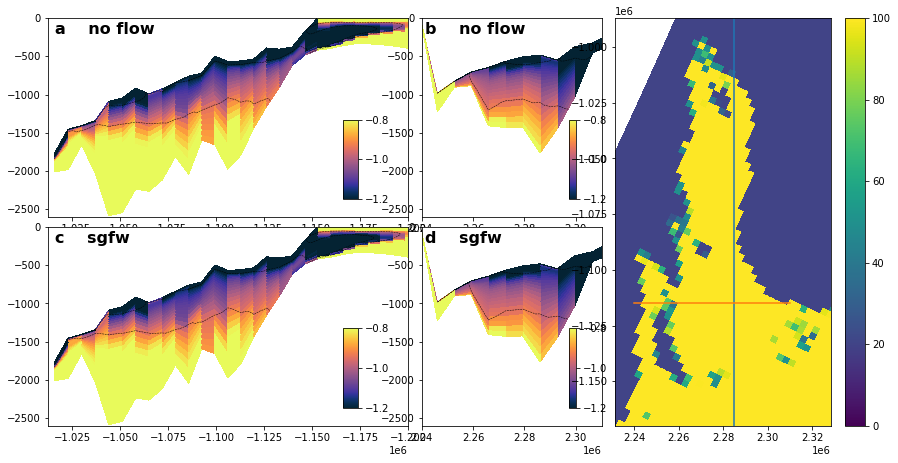

In [ ]:


gs = gridspec.GridSpec(nrows=2,ncols=3,wspace=0.05, hspace=0.05,width_ratios=[2, 1, 1.5])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,7.5])
ax = None

ax=fig.add_subplot(gs[0,0])
im=ax.pcolormesh(noflow_Y_2,noflow_Z_2,noflow_temp_2.squeeze(),vmin=-1.2,vmax=-.8,cmap='cmo.thermal')
co=ax.contour(noflow_Y_2,noflow_Z_2,noflow_temp_2.squeeze(),levels=np.arange(-1.2,-0.8,.25),colors='k',linewidths=0.5)
ax.set_xlim([-1.20e6,-1.0125e6])
#plt.xlim([-1.50e6,-.975e6])
ax.set_ylim([-2600,0])
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im,cax=cax)
ax.invert_xaxis()
ax.text(0.02, 0.98, 'a    no flow', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')

ax=fig.add_subplot(gs[0,1])
im=ax.pcolormesh(noflow_X_1,noflow_Z_1,noflow_temp_1.squeeze(),vmin=-1.2,vmax=-0.8,cmap='cmo.thermal')
co=ax.contour(noflow_X_1,noflow_Z_1,noflow_temp_1.squeeze(),levels=np.arange(-1.2,-0.8,.25),colors='k',linewidths=0.5)
plt.xlim([2.2400e6,2.310e6])
plt.ylim([-2600,0])
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im,cax=cax)
ax.text(0.02, 0.98, 'b    no flow', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')

ax=fig.add_subplot(gs[1,0])
im=ax.pcolormesh(norm_Y_2,norm_Z_2,norm_temp_2.squeeze(),vmin=-1.2,vmax=-0.8,cmap='cmo.thermal')
co=ax.contour(norm_Y_2,norm_Z_2,norm_temp_2.squeeze(),levels=np.arange(-1.2,-0.8,.25),colors='k',linewidths=0.5)
ax.set_xlim([-1.20e6,-1.0125e6])
#plt.xlim([-1.50e6,-.975e6])
ax.set_ylim([-2600,0])
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im,cax=cax)
ax.invert_xaxis()
ax.text(0.02, 0.98, 'c    sgfw', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')

ax=fig.add_subplot(gs[1,1])
im=ax.pcolormesh(norm_X_1,norm_Z_1,norm_temp_1.squeeze(),vmin=-1.2,vmax=-0.8,cmap='cmo.thermal')
co=ax.contour(norm_X_1,norm_Z_1,norm_temp_1.squeeze(),levels=np.arange(-1.2,-0.8,.25),colors='k',linewidths=0.5)
plt.xlim([2.2400e6,2.310e6])
plt.ylim([-2600,0])
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im,cax=cax)
ax.text(0.02, 0.98, 'd    sgfw', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')


ax=fig.add_subplot(gs[0:2,2])
im = ax.pcolormesh(gridFile.x_rho,gridFile.y_rho,gridFile.h+gridFile.zice,vmin=0,vmax=100)
ax.axis('equal')
ax.set_xlim([2.240e6,2.32e6])
ax.set_ylim([-1.170e6,-.987e6])
fig.colorbar(im)
plt.plot([2.285e6,2.285e6],[-1.2e6,-.975e6])
plt.plot([2.24e6,2.31e6],[-1.115e6,-1.115e6])


NameError: name 'noflow_Y_2' is not defined

<Figure size 640x480 with 0 Axes>

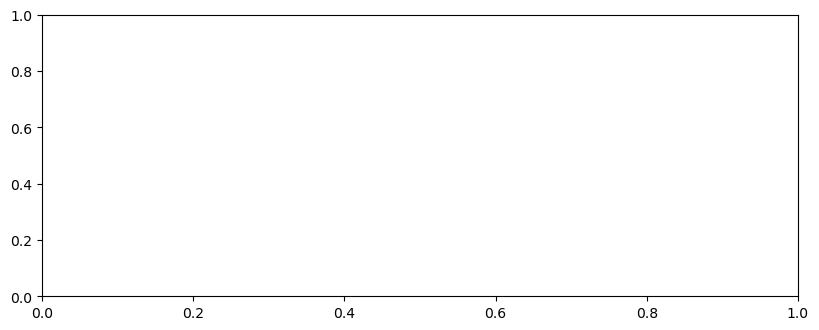

In [ ]:


gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.05, hspace=0.05,width_ratios=[2, 1])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,7.5])
ax = None

ax=fig.add_subplot(gs[0,0])
im=ax.pcolormesh(noflow_Y_2/1e3,noflow_Z_2,noflow_temp_2.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')
co=ax.contour(noflow_Y_2/1e3,noflow_Z_2,noflow_temp_2.squeeze(),levels=np.arange(-2,0,.25),colors='k',linewidths=0.5)
ax.set_xlim([-1.175e6/1e3,-1.0125e6/1e3])
#plt.xlim([-1.50e6,-.975e6])
ax.set_ylim([-2600,0])
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="75%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.86,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
cax.set_title('Pot. temp. ($^\circ$C)')
fig.colorbar(im,cax=cax)
ax.invert_xaxis()
ax.set_xticklabels([])
ax.text(0.02, 0.98, 'a   No flow', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')

ax=fig.add_subplot(gs[0,1])
im=ax.pcolormesh(noflow_X_1/1e3,noflow_Z_1,noflow_temp_1.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')
co=ax.contour(noflow_X_1/1e3,noflow_Z_1,noflow_temp_1.squeeze(),levels=np.arange(-2,0,.25),colors='k',linewidths=0.5)
plt.xlim([2.2400e6/1e3,2.310e6/1e3])
plt.ylim([-2600,0])
# cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.82,.09, .8, .8),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
# fig.colorbar(im,cax=cax)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.02, 0.98, 'b   No flow', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')

ax=fig.add_subplot(gs[1,0])
im=ax.pcolormesh(norm_Y_2/1e3,norm_Z_2,norm_temp_2.squeeze()-noflow_temp_2.squeeze(),vmin=-.1,vmax=0.1,cmap='cmo.balance')
co=ax.contour(norm_Y_2/1e3,norm_Z_2,norm_temp_2.squeeze()-noflow_temp_2.squeeze(),levels=np.arange(-.1,.1,.05),colors='k',linewidths=0.5)
ax.set_xlim([-1.175e6/1e3,-1.0125e6/1e3])
#plt.xlim([-1.50e6,-.975e6])
ax.set_ylim([-2600,0])
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im,cax=cax)
cax.set_title('$\Delta$ temp. ($^\circ$C)')
ax.invert_xaxis()
ax.text(0.5, -0.2, 'Northings (km)',fontsize=14, va='top', ha='center', transform=ax.transAxes)
ax.text(-.1, 1.05, 'Depth (m)',fontsize=14, va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.tick_params('x',labelrotation=45)
ax.text(0.02, 0.98, 'c   $\Delta$ with SGFW', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')

ax=fig.add_subplot(gs[1,1])
im=ax.pcolormesh(norm_X_1/1e3,norm_Z_1,norm_temp_1.squeeze()-noflow_temp_1.squeeze(),vmax=.1,vmin=-.1,cmap='cmo.balance')
co=ax.contour(norm_X_1/1e3,norm_Z_1,norm_temp_1.squeeze()-noflow_temp_1.squeeze(),levels=np.arange(-.1,.1,.05),colors='k',linewidths=0.5)
plt.xlim([2.2400e6/1e3,2.310e6/1e3])
plt.ylim([-2600,0])
# cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.82,.09, .8, .8),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
# fig.colorbar(im,cax=cax)
ax.set_yticklabels([])
ax.text(0.5, -0.2, 'Eastings (km)',fontsize=14, va='top', ha='center', transform=ax.transAxes)
ax.tick_params(labelrotation=45)
ax.text(0.02, 0.98, 'd    $\Delta$ with SGFW', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')



axins = fig.add_axes([.95, .3, 0.15, 0.4])
im = axins.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,gridFile.h.where(norm.zice!=0,np.nan),vmin=0,vmax=3000,cmap='cmo.deep',shading='nearest')
co = axins.contour(gridFile.x_rho/1000,gridFile.y_rho/1000,gridFile.h.where(norm.zice!=0,np.nan),levels=[0,1000,2000,3000],colors='k',vmin=0,vmax=3000,linewidths=0.5)
axins.axis('equal')
axins.set_xlim([2.240e3,2.32e3])
axins.set_ylim([-1.170e3,-.987e3])
fig.colorbar(im)
plt.plot([2.285e3,2.285e3],[-1.175e3,-1.0125e3],color='C3')
plt.plot([2.24e3,2.31e3],[-1.115e3,-1.115e3],color='C3')
axins.text(0.02, 0.98, ' e   ', transform=axins.transAxes,fontsize=16, fontweight='bold', va='top')
axins.text(0.54, 0.1, ' A   ', transform=axins.transAxes,fontsize=16, va='top')
axins.text(0.75, 0.33, ' B   ', transform=axins.transAxes,fontsize=16, va='top')


### reviewer comment
##### (1) It is important to add ice front vertical sections in Fig. S3, for example, along the observed section in Rintoul et al., 2016. This ice front section is observed several times and will be repeated in the future. Plotting a similar vertical section will help readers understand the model-data agreement and the impact of subglacial discharge. I also would like to see a few sentences comparing ice front sections with observations.

In [25]:
# 034 Totten 31 Dec 2014 235747 66 32.34 S 116 20.78 E 657 001159 66 32.40 S 116 20.65 E 718 004024 66 32.40 S 116 20.74 E 627 8.0 718
# 035 Totten 01 Jan 2015 060254 66 36.61 S 116 25.25 E 890 061948 66 36.56 S 116 25.28 E 915 070341 66 36.75 S 116 25.36 E 912 8.1 918
# 036 Totten 01 Jan 2015 084119 66 39.02 S 116 26.93E 1098 090120 66 39.07 S 116 27.07 E 1096 095108 66 39.11 S 116 27.29 E 1007 7.8 1102
# 037 Totten 01 Jan 2015 120529 66 43.17 S 116 32.08 E 584 121511 66 43.15 S 116 32.09 E 591 124614 66 43.23 S 116 32.03 E 585 9.0 588
# 038 Totten 01 Jan 2015 141018 66 47.84 S 116 37.46 E 510 142109 66 47.83 S 116 37.46 E 509 145435 66 47.80 S 116 37.55 E 508 9.0 506
# 039 Totten 01 Jan 2015 163039 66 47.90 S 116 47.22 E 428 164121 66 47.90 S 116 47.25 E 426 170817 66 47.88 S 116 47.24 E 427 10.0 421
# 040 Totten 01 Jan 2015 180822 66 47.72 S 116 56.97 E 704 182324 66 47.66 S 116 57.07 E 766 185420 66 47.60 S 116 56.92 E 742 9.2 766
# 041 Totten 01 Jan 2015 221504 66 49.67 S 117 09.44 E 663 222907 66 49.67 S 117 09.44 E 662 225948 66 49.67 S 117 09.44 E 660 4.7 665
# 042 Totten 02 Jan 2015 001333 66 49.15 S 117 21.74 E 440 002234 66 49.15 S 117 21.74 E 440 004224 66 49.15 S 117 21.74 E 440 7.9 437
# 043 Totten 02 Jan 2015 014321 66 48.83 S 117 34.10 E 402 015252 66 48.82 S 117 34.01 E 428 021758 66 48.82 S 117 34.00 E 403 8.2 424

def dm(deg,min):
    minutes = min/60
    degrees = np.sign(deg)*(np.abs(deg)+minutes)
    return degrees

au1402=np.empty((10,2))
au1402[0,:]=dm(-66,32.40),dm(116,20.65)
au1402[1,:]=dm(-66,36.56),dm(116,25.28)
au1402[2,:]=dm(-66,39.07),dm(116,27.07)
au1402[3,:]=dm(-66,43.15),dm(116,32.09)
au1402[4,:]=dm(-66,47.83),dm(116,37.46)
au1402[5,:]=dm(-66,47.90),dm(116,47.25)
au1402[6,:]=dm(-66,47.66),dm(116,57.07)
au1402[7,:]=dm(-66,49.67),dm(117,09.44)
au1402[8,:]=dm(-66,49.15),dm(117,21.74)
au1402[9,:]=dm(-66,48.82),dm(117,34.01)

# convert convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

au1402_psx,au1402_psy = ll_to_ps.transform(au1402[:,0],au1402[:,1])
au1402_ps=[au1402_psx,au1402_psy]


In [232]:
def interpProfilePS(x1,y1,x2,y2,no):
    X = np.linspace(x1,x2,no)
    Y = np.linspace(y1,y2,no)
    return X,Y


def makeProfilePS(x,y,no):
    x1=x[0:-1]
    y1=y[0:-1]
    x2=x[1:]
    y2=y[1:]
    
    N = x1.shape[0]
    Np = N*no
    Xi = np.empty(Np)
    Yi = np.empty(Np)
    print(N)
    print(Np)
    print(Xi.shape)
    for n in range(N):
        print('interpolating locations at points',n+1,' to ',n+2)
        print(n)
        print((n+1)*no-1)
        Xi[n*no:(n+1)*no],Yi[n*no:(n+1)*no] = interpProfilePS(x1[n],y1[n],x2[n],y2[n],5)
    
    return Xi,Yi
    

test_x,test_y = makeProfilePS(au1402_psx,au1402_psy,5)
    

9
45
(45,)
interpolating locations at points 1  to  2
0
4
interpolating locations at points 2  to  3
1
9
interpolating locations at points 3  to  4
2
14
interpolating locations at points 4  to  5
3
19
interpolating locations at points 5  to  6
4
24
interpolating locations at points 6  to  7
5
29
interpolating locations at points 7  to  8
6
34
interpolating locations at points 8  to  9
7
39
interpolating locations at points 9  to  10
8
44


In [187]:
def distance_haversine(lat1, lon1, lat2, lon2):
    from math import sin, cos, sqrt, atan2, radians

    # Approximate radius of earth in km
    R = 6373.0

    # lat1 = radians(52.2296756)
    # lon1 = radians(21.0122287)
    # lat2 = radians(52.406374)
    # lon2 = radians(16.9251681)
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance


def pathdist(lat1Vec,lon1Vec,lat2Vec,lon2Vec):
    N=lat1Vec.shape[0]
    distance = np.empty(N)
    for n in range(N):
        print('calculating distance at points',n+1,' to ',n+2)
        distance[n] = distance_haversine(lat1Vec[n],lon1Vec[n],lat2Vec[n],lon2Vec[n])
    np.cumsum(distance)
    distance=(0,*np.cumsum(distance))
    return distance
        
        
au1402_dist=pathdist(au1402[0:-1,0],au1402[0:-1,1],au1402[1:,0],au1402[1:,1])

calculating distance at points 1  to  2
calculating distance at points 2  to  3
calculating distance at points 3  to  4
calculating distance at points 4  to  5
calculating distance at points 5  to  6
calculating distance at points 6  to  7
calculating distance at points 7  to  8
calculating distance at points 8  to  9
calculating distance at points 9  to  10


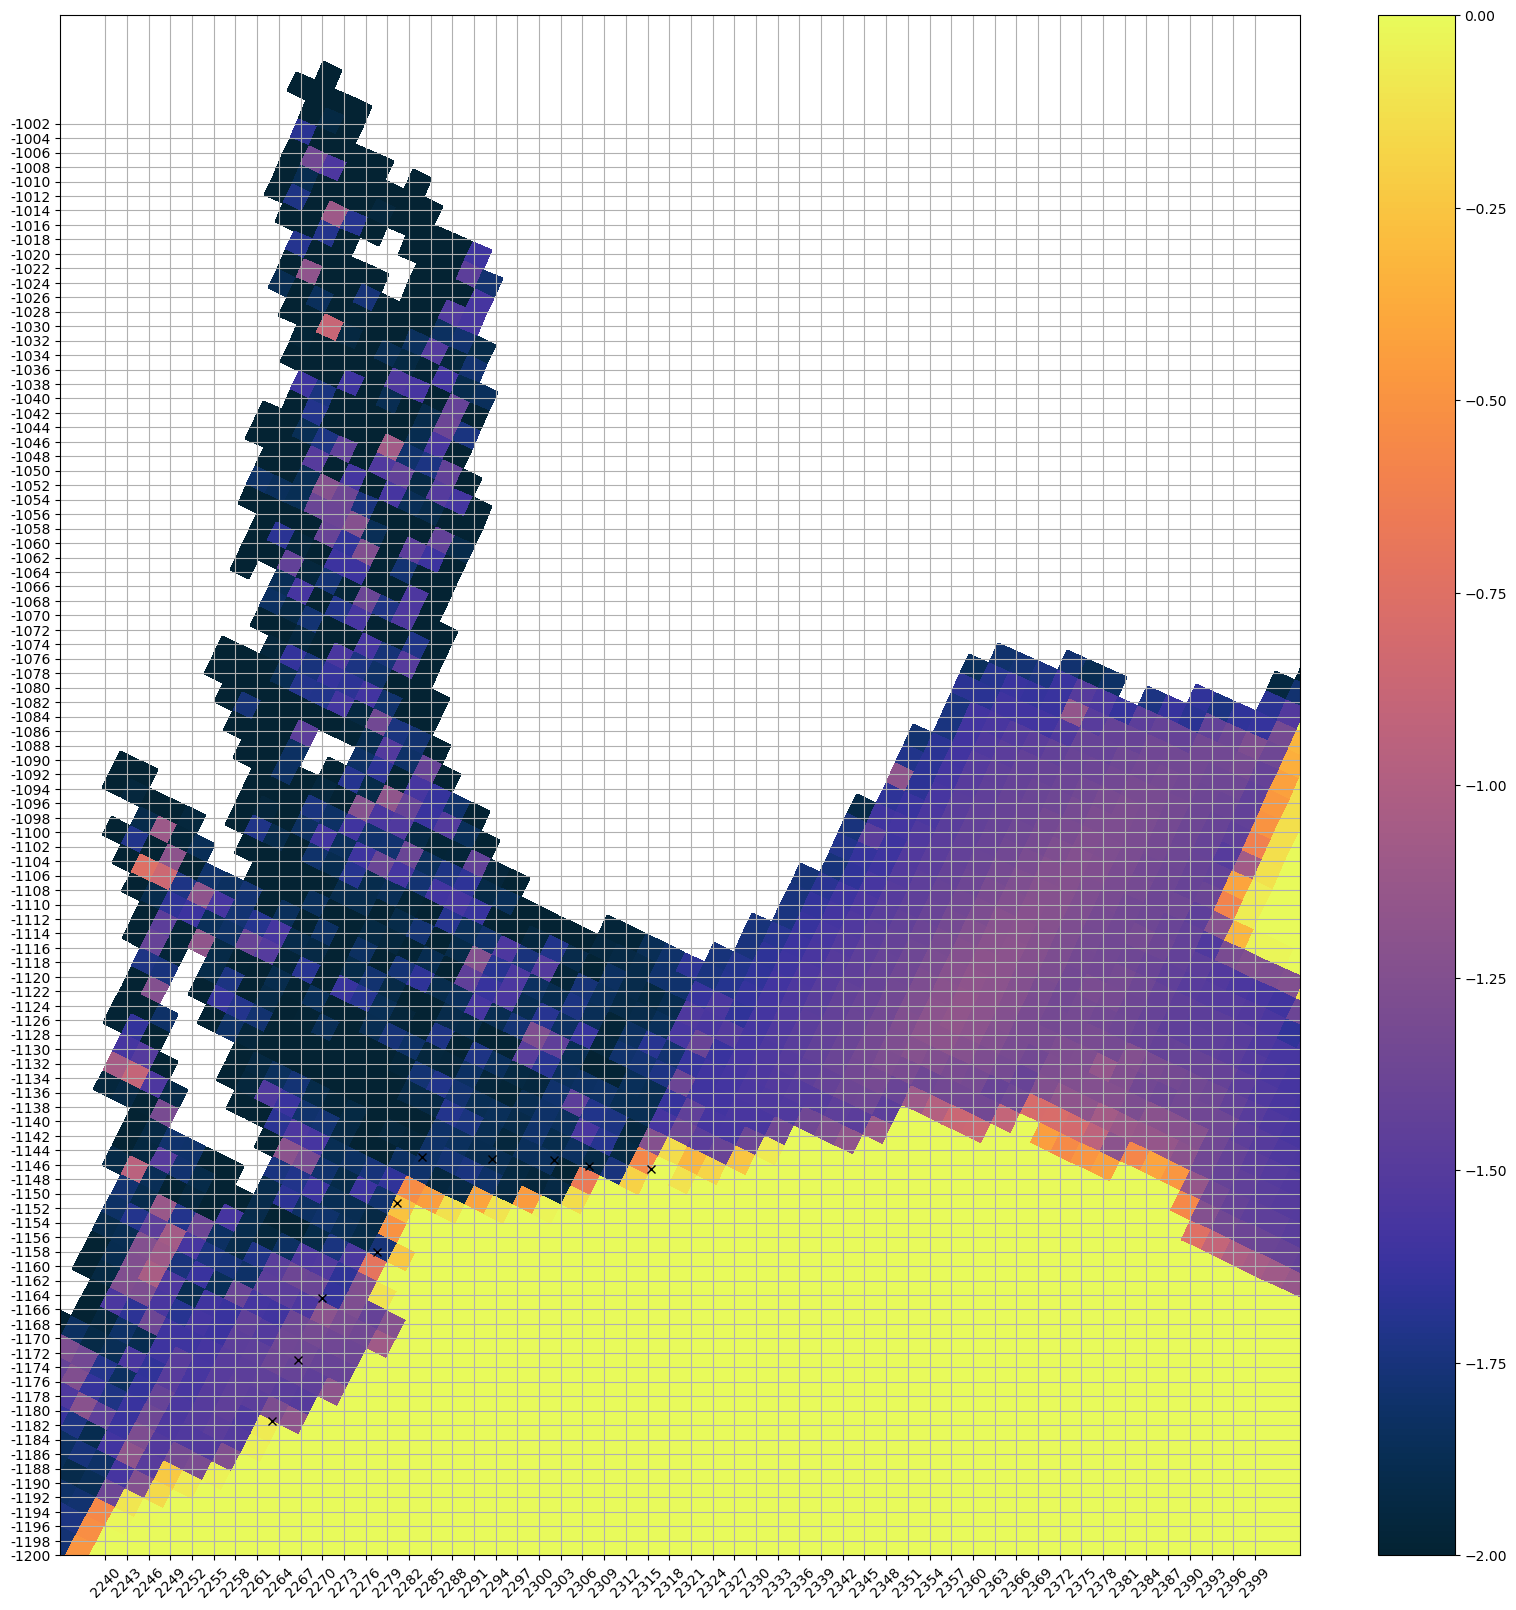

In [247]:
plt.figure(figsize=(20,20))
im=plt.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,norm.temp.isel(s_rho=-1).mean(dim='ocean_time'),vmin=-2,vmax=0,cmap='cmo.thermal')
plt.axis('equal')
plt.xlim([2.240e3,2.32e3])
plt.ylim([-1.20e3,-.987e3])
plt.colorbar(im)
plt.plot(au1402_psx/1000,au1402_psy/1000,'kx')
plt.xticks(np.arange(2240,2400,3),np.arange(2240,2400,3),rotation=45)
plt.yticks(np.arange(-1200,-1000,2),np.arange(-1200,-1000,2))
plt.grid()


In [111]:
def extract_tracer_values(xq,yq,tracer,x,y,z):
    from scipy.interpolate import griddata
    N=tracer.shape[0]
    tracer_q=np.empty((N))
    tracer_z=np.empty((N))
    for k in range(N):
        # print('...vertical level ', str(k+1), ' of ', str(N))
        tracer_q[k] = griddata((x.values.flatten(),y.values.flatten()), tracer.isel(s_rho=k).values.flatten(), (xq,yq), method='nearest')
        tracer_z[k] = griddata((x.values.flatten(),y.values.flatten()),z.isel(s_rho=k).values.flatten(),(xq,yq),method='nearest')
        
    return tracer_q,tracer_z
    


def extract_tracer_transect(xq,yq,tracer,x,y,z):
    Np=xq.shape[0]
    N = tracer.shape[0]
    tracer_Q = np.empty((N,Np))
    tracer_Z = np.empty((N,Np))
    
    for p in range(Np):
        print('... point number ', str(p+1), ' of ', str(Np))
        xqq = xq[p]
        yqq = yq[p]
        tracer_Q[:,p],tracer_Z[:,p] = extract_tracer_values(xqq,yqq,tracer,x,y,z)
        
    return tracer_Q,tracer_Z


# tracer_q,tracer_z = extract_tracer_values(2325e3,-1125e3,norm.temp.mean(dim='ocean_time'),norm.x_rho,norm.y_rho,norm.z_rho)

# griddata((gridFile.x_rho.values.flatten(),gridFile.y_rho.values.flatten()),norm.temp.isel(s_rho=-1).mean(dim='ocean_time').values.flatten(),(2325e3,-1125e3))

XQ=np.array((2325e3,2300e3))
YQ=np.array((-1125e3,-1126e3))
tracer_Q,tracer_Z = extract_tracer_transect(XQ,YQ,norm.temp.mean(dim='ocean_time'),norm.x_rho,norm.y_rho,norm.z_rho)



... point number  1  of  2
...vertical level  1  of  31
...vertical level  2  of  31
...vertical level  3  of  31
...vertical level  4  of  31
...vertical level  5  of  31
...vertical level  6  of  31
...vertical level  7  of  31
...vertical level  8  of  31
...vertical level  9  of  31
...vertical level  10  of  31
...vertical level  11  of  31
...vertical level  12  of  31
...vertical level  13  of  31
...vertical level  14  of  31
...vertical level  15  of  31
...vertical level  16  of  31
...vertical level  17  of  31
...vertical level  18  of  31
...vertical level  19  of  31
...vertical level  20  of  31
...vertical level  21  of  31
...vertical level  22  of  31
...vertical level  23  of  31
...vertical level  24  of  31
...vertical level  25  of  31
...vertical level  26  of  31
...vertical level  27  of  31
...vertical level  28  of  31
...vertical level  29  of  31
...vertical level  30  of  31
...vertical level  31  of  31
... point number  2  of  2
...vertical level  1  of 

In [190]:

XQ=au1402_psx
YQ=au1402_psy
tracer_Q,tracer_Z = extract_tracer_transect(XQ,YQ,norm.temp.mean(dim='ocean_time'),norm.x_rho,norm.y_rho,norm.z_rho)
tracer_X=np.matlib.repmat(au1402_dist,norm.z_rho.shape[0],1)

... point number  1  of  10
...vertical level  1  of  31
...vertical level  2  of  31
...vertical level  3  of  31
...vertical level  4  of  31
...vertical level  5  of  31
...vertical level  6  of  31
...vertical level  7  of  31
...vertical level  8  of  31
...vertical level  9  of  31
...vertical level  10  of  31
...vertical level  11  of  31
...vertical level  12  of  31
...vertical level  13  of  31
...vertical level  14  of  31
...vertical level  15  of  31
...vertical level  16  of  31
...vertical level  17  of  31
...vertical level  18  of  31
...vertical level  19  of  31
...vertical level  20  of  31
...vertical level  21  of  31
...vertical level  22  of  31
...vertical level  23  of  31
...vertical level  24  of  31
...vertical level  25  of  31
...vertical level  26  of  31
...vertical level  27  of  31
...vertical level  28  of  31
...vertical level  29  of  31
...vertical level  30  of  31
...vertical level  31  of  31
... point number  2  of  10
...vertical level  1  o

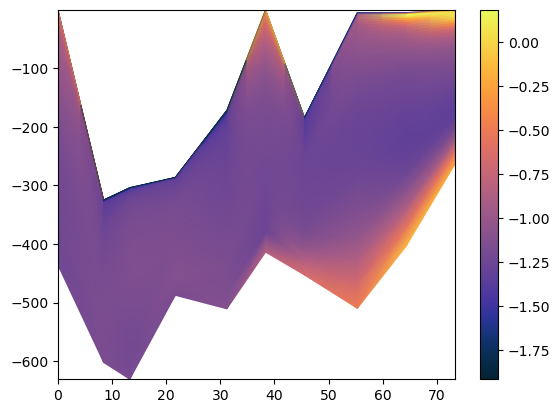

In [208]:
plt.pcolormesh(tracer_X,tracer_Z,tracer_Q,cmap='cmo.thermal',shading='gouraud')
plt.colorbar()

In [264]:
# convert convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

if_ocean_lat,if_ocean_lon = ps_to_ll.transform(if_ocean[:,0]*1000,if_ocean[:,1]*1000)


(array([-66.37923222, -66.7432763 , -66.70265479, -66.7716425 ,
        -66.92495521]),
 array([116.13174656, 116.83521789, 117.18433291, 117.57699102,
        118.13882604]))

In [283]:
if_ocean=np.empty((5,2))
if_ocean[0,:]=2336,-1146
if_ocean[1,:]=2285,-1156
if_ocean[2,:]=2282,-1172
if_ocean[3,:]=2267,-1184
if_ocean[4,:]=2240,-1198

if_ice=np.empty((6,2))
if_ice[0,:]=2336,-1138
if_ice[1,:]=2288,-1148
if_ice[2,:]=2279,-1149
if_ice[3,:]=2273,-1168
if_ice[4,:]=2267,-1177
if_ice[5,:]=2240,-1190

if_ocean = if_ocean*1000
if_ice = if_ice*1000


if_ocean_hr_x,if_ocean_hr_y = makeProfilePS(if_ocean[:,0],if_ocean[:,1],5)
if_ocean_hr_lat,if_ocean_hr_lon = ps_to_ll.transform(if_ocean_hr_x,if_ocean_hr_y)
if_ocean_hr_dist=pathdist(if_ocean_hr_lat[0:-1],if_ocean_hr_lon[0:-1],if_ocean_hr_lat[1:],if_ocean_hr_lon[1:])
if_ocean_temp,if_ocean_Z = extract_tracer_transect(if_ocean_hr_x,if_ocean_hr_y,norm.temp.mean(dim='ocean_time'),norm.x_rho,norm.y_rho,norm.z_rho)
ocean_temp_X=np.matlib.repmat(if_ocean_hr_dist,norm.z_rho.shape[0],1)

if_ice_hr_x,if_ice_hr_y = makeProfilePS(if_ice[:,0],if_ice[:,1],5)
if_ice_hr_lat,if_ice_hr_lon = ps_to_ll.transform(if_ice_hr_x,if_ice_hr_y)
if_ice_hr_dist=pathdist(if_ice_hr_lat[0:-1],if_ice_hr_lon[0:-1],if_ice_hr_lat[1:],if_ice_hr_lon[1:])
if_ice_temp,if_ice_Z = extract_tracer_transect(if_ice_hr_x,if_ice_hr_y,norm.temp.mean(dim='ocean_time'),norm.x_rho,norm.y_rho,norm.z_rho)
ice_temp_X=np.matlib.repmat(if_ice_hr_dist,norm.z_rho.shape[0],1)



4
20
(20,)
interpolating locations at points 1  to  2
0
4
interpolating locations at points 2  to  3
1
9
interpolating locations at points 3  to  4
2
14
interpolating locations at points 4  to  5
3
19
calculating distance at points 1  to  2
calculating distance at points 2  to  3
calculating distance at points 3  to  4
calculating distance at points 4  to  5
calculating distance at points 5  to  6
calculating distance at points 6  to  7
calculating distance at points 7  to  8
calculating distance at points 8  to  9
calculating distance at points 9  to  10
calculating distance at points 10  to  11
calculating distance at points 11  to  12
calculating distance at points 12  to  13
calculating distance at points 13  to  14
calculating distance at points 14  to  15
calculating distance at points 15  to  16
calculating distance at points 16  to  17
calculating distance at points 17  to  18
calculating distance at points 18  to  19
calculating distance at points 19  to  20
... point number  

/tmp/ipykernel_929/2560637721.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ocean_temp_X,if_ocean_Z,if_ocean_temp,cmap='cmo.thermal',shading='auto')


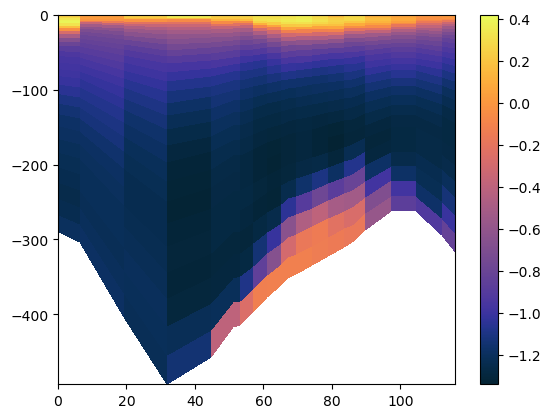

/tmp/ipykernel_929/2560637721.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ice_temp_X,if_ice_Z,if_ice_temp,cmap='cmo.thermal',shading='auto')


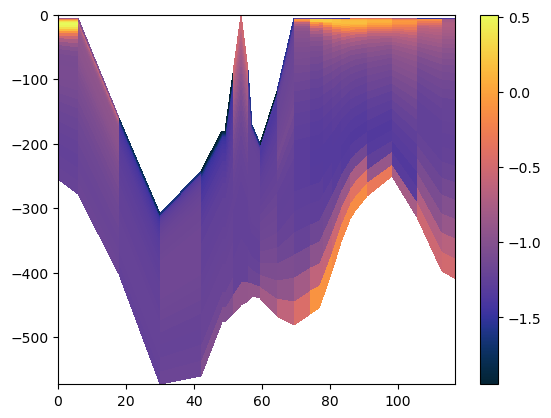

In [284]:
plt.pcolormesh(ocean_temp_X,if_ocean_Z,if_ocean_temp,cmap='cmo.thermal',shading='auto')
plt.xlim(np.min(if_ocean_hr_dist),np.max(if_ocean_hr_dist))
plt.colorbar()
plt.show()
plt.pcolormesh(ice_temp_X,if_ice_Z,if_ice_temp,cmap='cmo.thermal',shading='auto')
plt.xlim(np.min(if_ice_hr_dist),np.max(if_ice_hr_dist))
plt.colorbar()